In [1]:
# from statistics import median
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import nmrglue as ng


# import pulsee.simulation as sim
from plot_dm import plot_complex_density_matrix

import tomography_helper_functions
import tomography_helper_functions as helper
# from tomography.tomography_helper_functions import projection_fortunato, plot_spectra_together
# from tomography.tomography_helper_functions import index_to_element, integrate_simpson, integrate_optimized

# import * is bad practice, but this is the easiest way to do quick theoretical calculations with this many variables.
import operators as op
import global_constants as glob
from coeff_groups_class import CoefficientGroups

from temporal_average import temporal_average

# commented out cuz it causes my computer to not plot anything:
#%matplotlib notebook

plt.rcParams['figure.dpi'] = glob.DPI_DISPLAY

In [2]:
# DIFFERENT FOR THIS MEASUREMENT!
SPECTRUM_WIDTH = 2000  # Hz


# assert np.array_equal(freqs, freqs_local)

#B_0 = 14.0921  # Tesla
J = 21.59  # Hz
L_FREQ = -J/2
R_FREQ = J/2
PHASE_0=-33
#-27=88.55
#-35=88.70
#-31=88.76
#-33=
# probably won't need...?
#SPECTRUM_OFFSET = 49697.66
#w_1_Bruker = 202474441.0  # Hz
#w_2_Bruker = 202475194.8  # Hz
#TEMP = 310  # Kelvin

# Importing Data
Rearranged folders (from Donny's usual format) so that both P1 and P2 files are in the same folder. This way I don't have to deal with separate "P1" and "P2" folders.

findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.


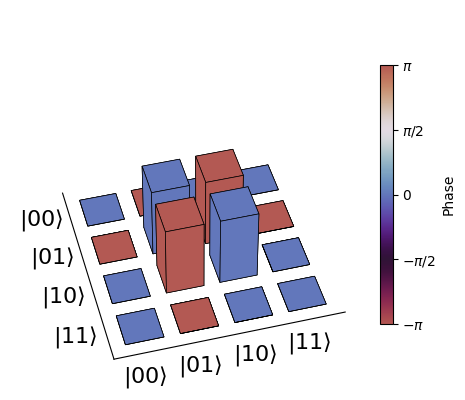

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.28699736e-34 -1.62588396e-17  1.62588396e-17  3.82918222e-33]
 [-1.62588396e-17  4.99999995e-01 -4.99999995e-01 -1.17756933e-16]
 [ 1.62588396e-17 -4.99999995e-01  4.99999995e-01  1.17756933e-16]
 [ 3.82918222e-33 -1.17756933e-16  1.17756933e-16  2.77333909e-32]]

In [3]:
state_name = "0001BPA_155"
rho_theory = rho_theory = op.CNOT_Phased*op.H_1*op.CLEAN_0001*op.H_1.dag()*op.CNOT_Phased.dag()
plot_complex_density_matrix(rho_theory)
display(rho_theory)

In [4]:
# Bruker_folders_path = r"C:\Users\lemon\OneDrive - Brown University\CNOT project\tomography\data\Br-uker_folders\2024_12_13"
data_folder = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\Final_Organized_MIT_DATA\2024_12_20-21\0001BPA_155"

Flip the frequency axis

# Calculating the frequency axis for the spectrum
All data in below cell is from Donny's email & Bruker plots

According to Bruker's software, the middle of the spectrum should be the experimental larmor frequency (with chemical shift included), and we can set this to 0 Hz. In other words, the frequency axis range is: (-spectrum_width/2, spectrum/2), with 0 in the middle, and left peak should occur at -$J$ and right peak at $J$

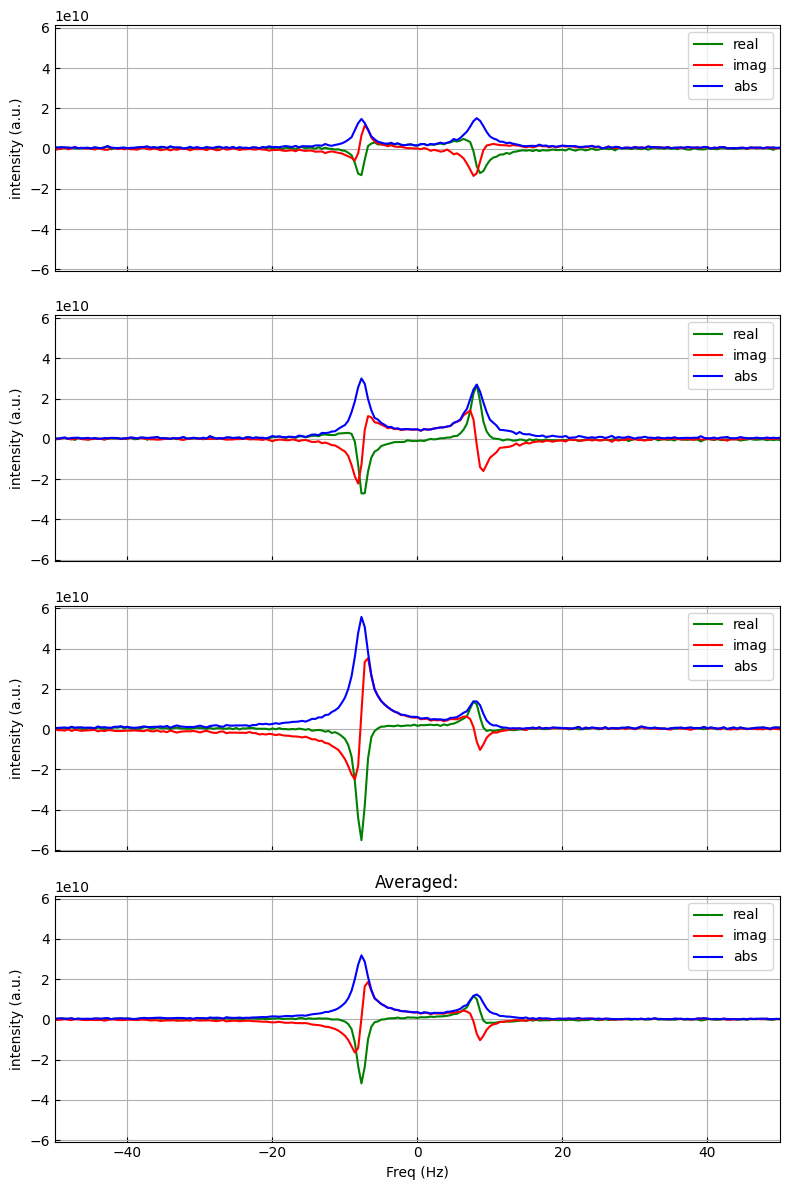

In [5]:
freqs, all_spectra_complex = temporal_average(data_folder, display_avg=True, DISPLAY_I=5, PHASE_0=PHASE_0)

In [6]:
freqs

array([-727.04545455, -726.59105114, -726.13664773, ...,  725.68224432,
        726.13664773,  726.59105114])

In [7]:

freqs_local = np.linspace(-SPECTRUM_WIDTH / 2, SPECTRUM_WIDTH / 2, all_spectra_complex.shape[1])

In [8]:
all_spectra = np.zeros((all_spectra_complex.shape[0] * 2, all_spectra_complex.shape[1]))

for i in range(all_spectra_complex.shape[0]):
    all_spectra[i * 2, :] = all_spectra_complex[i, :].real
    all_spectra[i * 2 + 1, :] = all_spectra_complex[i, :].imag

all_spectra.shape

(28, 3200)

# Plotting Everything Together

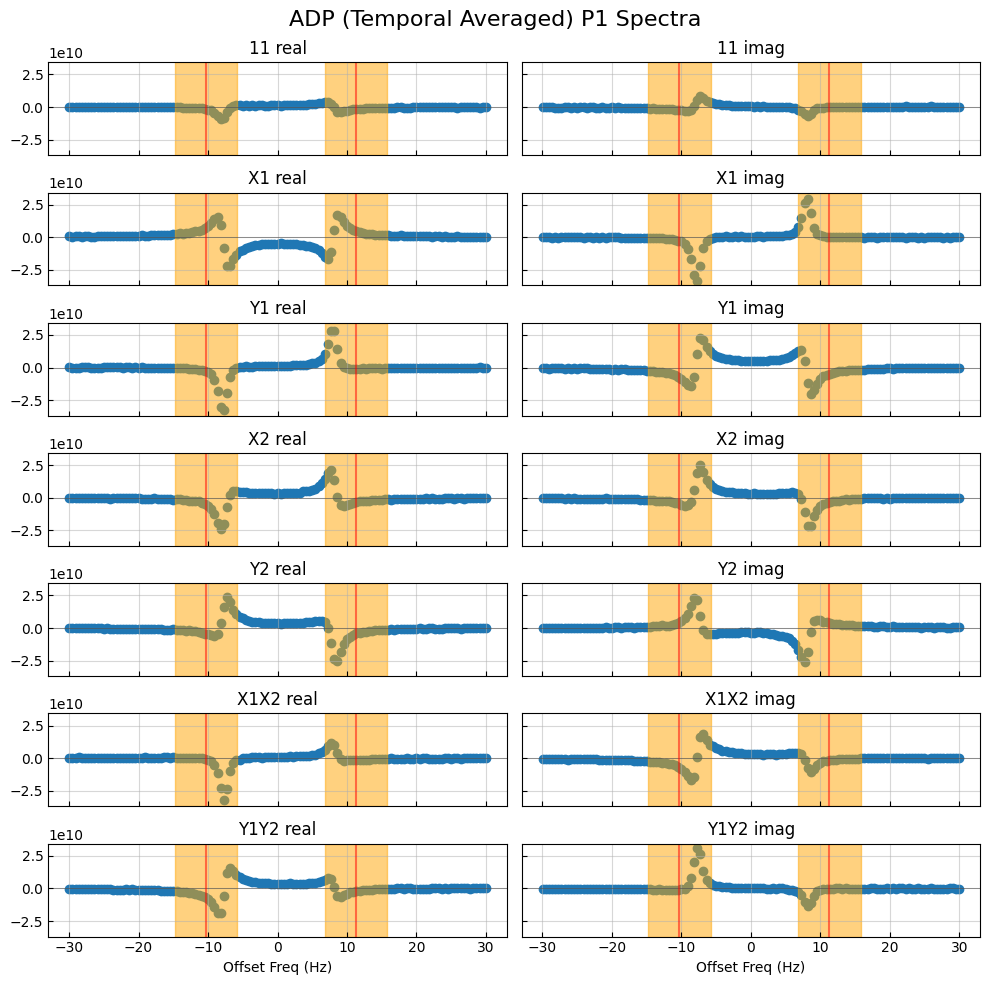

In [9]:
INT_WIDTH = 9  # in Hz. The width to integrate over.
X_LIMS_DISPLAY = [-30, 30]


# Making an offset so the red lines visually line up with the peaks
p1_offset =0.5
p1_freqs = (L_FREQ + p1_offset, R_FREQ + p1_offset)

fig_1, axs_1 = helper.plot_spectra_together(freqs, all_spectra[:all_spectra.shape[0]//2],
                                     glob.SPECTRA_NAMES, X_LIMS_DISPLAY, p1_freqs[0], p1_freqs[1], int_width=INT_WIDTH, share_y=True)
fig_1.suptitle('ADP (Temporal Averaged) P1 Spectra', size=16)
fig_1.tight_layout()
plt.show()

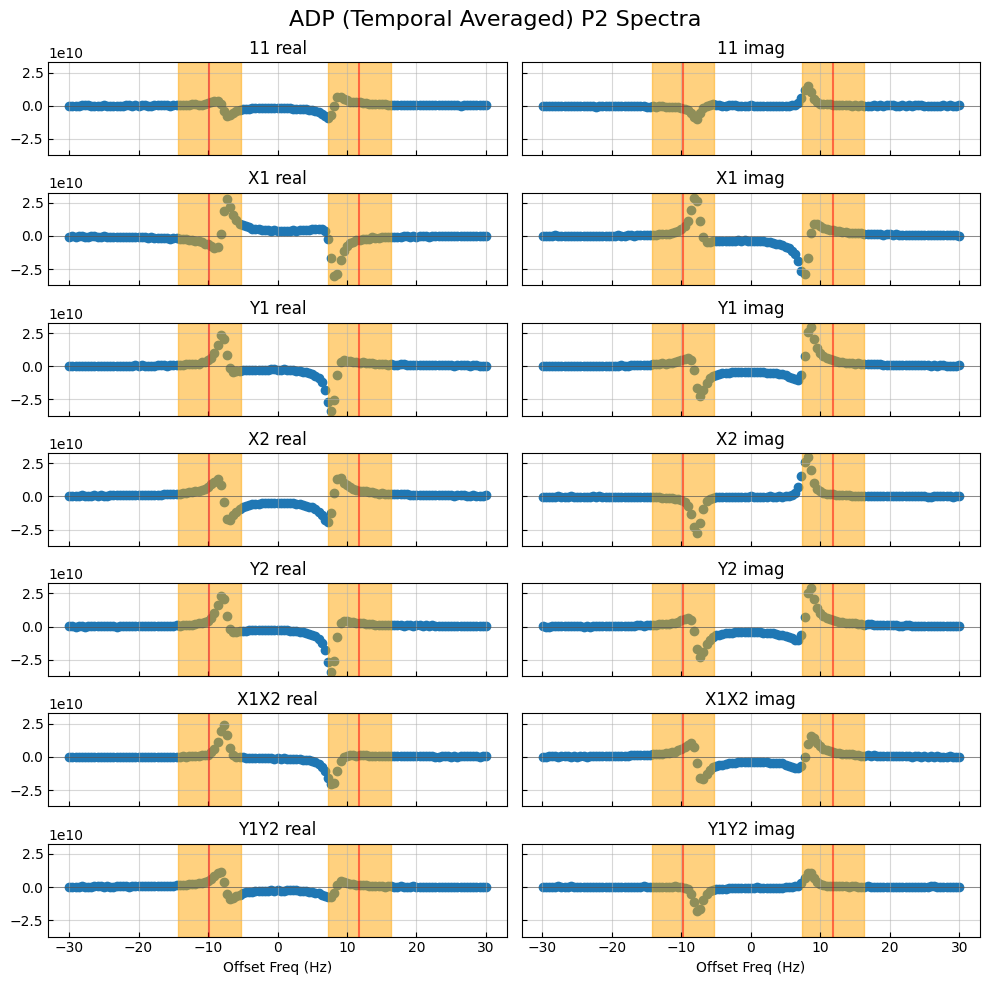

In [10]:
# Making an offset so the red lines visually line up with the peaks
p2_offset = 1
p2_freqs = (L_FREQ + p2_offset, R_FREQ + p2_offset)

fig_2, axs_2 = helper.plot_spectra_together(freqs, all_spectra[all_spectra.shape[0] // 2:], glob.SPECTRA_NAMES, X_LIMS_DISPLAY, p2_freqs[0], p2_freqs[1], int_width=INT_WIDTH, share_y=True)
fig_2.suptitle('ADP (Temporal Averaged) P2 Spectra', size=16)
fig_2.tight_layout()
plt.show()


# Preparing for Tomography Calculations:

We use convention of using the "I" to denote the first spin ($I_1$) and "S" the second spin ($I_2$)

$(I=I_1, S=I_2)$

Quick Check that our pulse sequences covers all 15 basis operators (not necessary)

In [11]:
op.check_basis_complete()

Operator basis is complete (15 elements)


# Three Methods for calculating coefficients

1. Just the height of the spectrum at the expected peak locations
2. Integration of peaks (simpson method & trapezoid method, but both seem to give almost identical answers)
3. (no longer used) Fitting a theoretical Lorentzian model to our data using scipy.curve_fit

## First approach: get height of one data point closest to theoretical peak locations

### Construct a "`coefficient groups`". 
"coefficient groups" is a list of "group"s, with each group being a list of:

`[operator, (c1, spectrum type), (c2, spectrum type), (c3, spectrum type), ...]`

where the first element of the group is a product operator,

and the following elements are tuples of: (coefficients corresponding to that operator, the type of spectrum which the coefficient came from).

In the case of ADP there are two spectrum types: P1 and P2

(each spectrum produces two coefficients)

In [12]:
coeff_groups_height = CoefficientGroups()

for (i, spectrum) in enumerate(all_spectra):
    # Height of the point closest to each peak's frequency location
    L = spectrum[np.absolute(freqs - L_FREQ).argmin()]
    R = spectrum[np.absolute(freqs - R_FREQ).argmin()]
    coeff_groups_height.add_coefficient(op.product_operators[i][0], L + R, helper.index_to_element(i))
    coeff_groups_height.add_coefficient(op.product_operators[i][1], L - R, helper.index_to_element(i))
    # print(f"Spectrum {thermal_col_names[i]} L+R is: {(L+R):.1e}, L-R is {(L-R):.1e}")

print(f'number of groups is: {len(coeff_groups_height.data)} (<- should be 15)')

number of groups is: 15 (<- should be 15)


Average the coefficients for each operator, and reconstruct the density matrix

## Second Approach: integrate the raw data
1. Integrate sample points using (`scipy.integrate.trapezoid`)
2. Integrate sample points using (`scipy.integrate.simpson`)

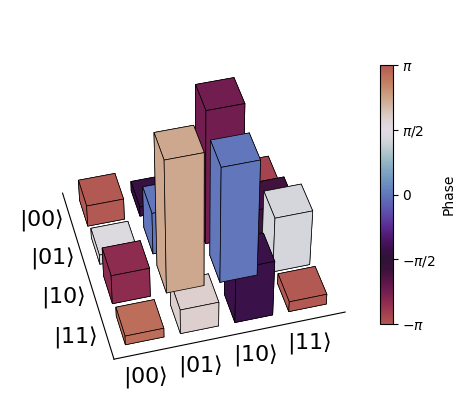

projection of naive integration: (0.6901546336365414-8.868852174338105e-18j)


In [13]:
rho_naive = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, INT_WIDTH, positive_diag=False)

plot_complex_density_matrix(rho_naive)
print(f"projection of naive integration: {helper.projection_fortunato(rho_naive, rho_theory)}")

### Integrating with various different parameters to find the integration with the largest projection value:

In [14]:
result_filename = f"result_{state_name}.pickle"
error_filename = f"result_{state_name}_error.pickle"
# result_filename = f"result_{state_name}.pickle"
# error_filename = f"result_{state_name}_error.pickle"

try:
    with open(result_filename, "rb") as result_file:
        best_rho_simpson, best_projection, best_offsets, best_int_width = pickle.load(result_file)
    print("Found previously saved result file!")
        
except FileNotFoundError:
    print("Couldn't find saved result. Integrating and saving the result...")
    best_rho_simpson, best_projection, best_offsets, best_int_width, rho_error = \
        helper.integrate_optimized(freqs, all_spectra, p1_freqs, p2_freqs, rho_theory, return_error=True)
                                   # p1_range=[0], p2_range=[0], width_range=[4])
    with open(result_filename, "wb") as result_file:
        pickle.dump([best_rho_simpson, best_projection, best_offsets, best_int_width], result_file)
    with open(error_filename, "wb") as error_file:
        pickle.dump(rho_error, error_file)


try:
    with open(error_filename, "rb") as error_file:
        rho_error = pickle.load(error_file)
    print("Found previously saved error file")
    
except FileNotFoundError: # in the case where result file exists but error file doesn't.
    print("Couldn't find saved error file. Calculating and saving error")
    rho_error = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, best_int_width,
                                         best_offsets[0], best_offsets[1], return_error=True)
    with open(error_filename, "wb") as error_file:
        pickle.dump(rho_error, error_file)
    

Couldn't find saved result. Integrating and saving the result...


AssertionError: 

In [ ]:
print(f"Best parameters: {best_offsets}, {best_int_width}")
print(f"Best projection: {best_projection}")
plot_complex_density_matrix(best_rho_simpson, label_size=12, label_qubit=True, save_to="")

In [ ]:
display(best_rho_simpson)

In [ ]:
np.min(best_rho_simpson.diag())

In [ ]:
best_rho_simpson - op.IDENTITY * np.min(best_rho_simpson.diag())

In [ ]:
import importlib
importlib.reload(tomography_helper_functions)
helper = tomography_helper_functions

print(f"qutip: {qt.fidelity(rho_theory, best_rho_simpson)}")
# print(f"standard: {helper.projection_jozsa(rho_theory, best_rho_simpson)}")
# print(f"standard reversed: {helper.projection_jozsa(best_rho_simpson, rho_theory)}")
# print(qt.fidelity(best_rho_simpson, rho_theory))
print(f"Fortunato: {helper.projection_fortunato(rho_theory, best_rho_simpson)}")

In [ ]:
(rho_theory.sqrtm() * best_rho_simpson * rho_theory.sqrtm()).sqrtm() ** 2